In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
from glob import glob
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt, spectrogram
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D

from filtering import freq_filt

In [5]:
import scipy.stats
import numpy as np
def mean_ci(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [6]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'

with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [17]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/psd_results'
# with open(join(result_dir, 'avg_Periodgram.pkl'), 'rb') as f:
#     avg_Pxx = pickle.load(f)
# with open(join(result_dir, 'pre_avg_Periodgram.pkl'), 'rb') as f:
#     pre_avg_Pxx  = pickle.load(f)
# with open(join(result_dir, 'avg_welch.pkl'), 'rb') as f:
#     avg_Pxx = pickle.load(f)
with open(join(result_dir,'avg_welch_writ.pkl'), 'rb') as f:
    avg_Pxx = pickle.load(f)
with open(join(result_dir, 'pre_avg_welch_writ.pkl'), 'rb') as f:
    pre_avg_Pxx  = pickle.load(f)
with open(join(result_dir, 'all_welchs.pkl'), 'rb') as f:
    all_Pxx = pickle.load(f)

In [ ]:
for windowfp in glob(join(result_dir,'windows', '*')):
    with open(windowfp, 'rb') as f:
        avg_Pxx = pickle.load(f)
    # f, ax = plt.subplots(figsize = (12,8))


    # (pre_avg_Pxx)[[0.33]].plot(linewidth = 1, ax = ax, color = 'black', legend = False)

    # (avg_Pxx- pre_avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 2, ax = ax, legend = True, color= ['darkblue','darkgreen','darkred','darkviolet'])
    # plt.xlim(1, 80)
    # plt.title(f'Average Eq Signal Power Spectral Density for window {basename(windowfp)}')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('PSD ($Pa^{2}/Hz$)')


    # ax.set_yticks([0])

    # legend = ax.get_legend()
    # handles, labels = ax.get_legend_handles_labels()
    # handles, labels = handles[1:], labels[1:]
    # handles.append(Line2D(xdata = [np.nan], ydata = [np.nan], color = 'black'))
    # labels.append("Sensor Self Noise")

    # legend._legend_box = None
    # legend._init_legend_box(handles, labels)
    # legend._set_loc(legend._loc)
    # legend.set_title(legend.get_title().get_text())
    # plt.show()
    f, ax = plt.subplots(figsize = (12,8))
    # comb = avg_Pxx- pre_avg_Pxx
    # comb[comb[1.33]<1e-10] = np.nan
    # # comb = comb.rolling(10).mean()
    # (comb)[[0.33,0.66,1,1.33]].div((comb)[0.33], axis = 0).plot(linewidth = 2, ax = ax)
    # plt.xlim(1, 50)
    # plt.ylim(-.1, 1.1)
    # plt.title('Average Ratio of 1.33m Sensor')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('PSD Ratio Relative to 1.33m Sensor')
    comb = avg_Pxx- pre_avg_Pxx
    comb[comb[1.33]<1e-10] = np.nan
    # comb = comb.rolling(10).mean()
    (comb)[[0.33,0.66,1]].div((comb)[1.33], axis = 0).plot(linewidth = 2, ax = ax)
    plt.xlim(1, 50)
    plt.ylim(-1, 25)
    plt.title(windowfp)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD Ratio Relative to 1.33m Sensor')
    plt.show()

In [ ]:
for k, v in all_Pxx.items():
    f, ax = plt.subplots()
    v[[0.33,0.66,1,1.33]].plot(ax =ax)
    plt.show()

# Plotting

40


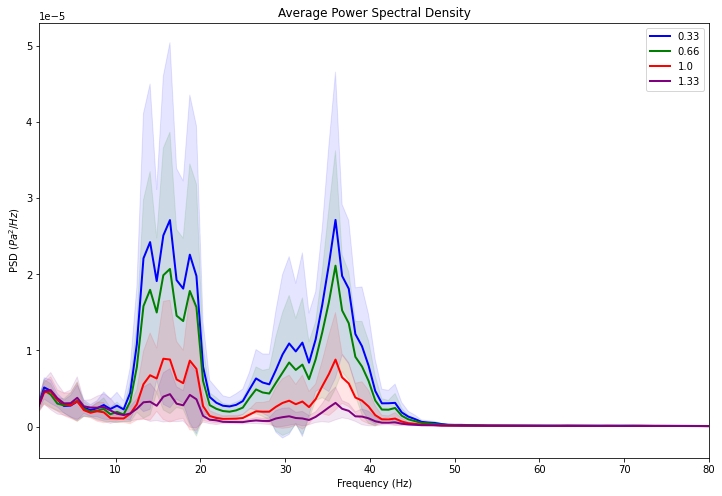

In [9]:
ci = {}
print(len(all_Pxx.keys()))
for h in [0.33,0.66,1,1.33]:
    res = pd.DataFrame()
    for i, (_, df) in enumerate(all_Pxx.items()):
        res.loc[:,i] = df[h]
    ci[h] = res.apply(mean_ci, axis = 1)
f, ax = plt.subplots(figsize = (12,8))
col_dic = {0.33:'blue',0.66:'green',1:'red',1.33:'purple'}
(avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 2, ax = ax, color= col_dic.values())
plt.xlim(1, 80) 
plt.title('Average Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
#plt.yticks([])
for h, series in ci.items():
    cis_split = pd.DataFrame()
    cis_split[['mean','lci','hci']] = pd.DataFrame(series.tolist(), index=series.index)
    ax.fill_between(cis_split.index, cis_split.lci, cis_split.hci, color=col_dic[h], alpha=.1)

In [13]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'font.family':'Arial',
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

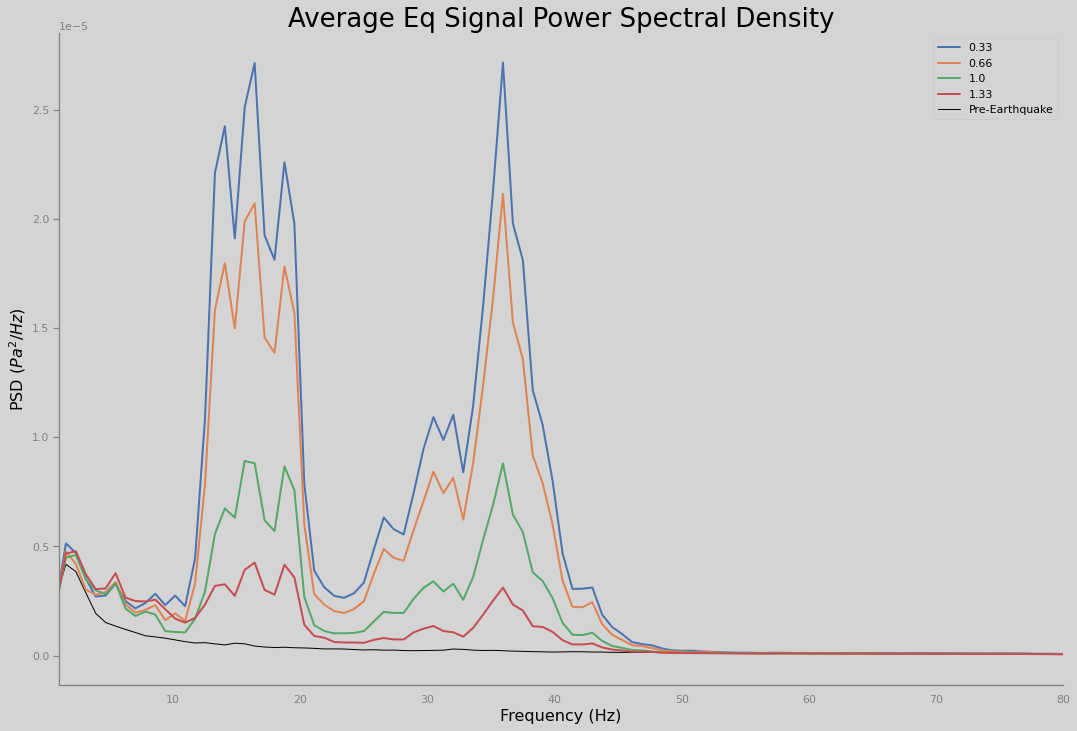

In [22]:
colorn = 0.83
f, ax = plt.subplots(facecolor = (colorn,colorn,colorn, 1.0))

# (avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax, color= ['blue','green','red','purple'])
# plt.xlim(1, 80)
# plt.title('Average Power Spectral Density')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD ($Pa^{2}/Hz$)')
# #plt.yticks([])

# f, ax = plt.subplots(figsize = (12,8))
(pre_avg_Pxx)[[0.33]].plot(linewidth = 1, ax = ax, color = 'black', legend = False)
# plt.xlim(1, 80)
# plt.title('Average Self-Noise Power Spectral Density')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD ($Pa^{2}/Hz$)')

# f, ax = plt.subplots(figsize = (12,8))
(avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 2, ax = ax, legend = True)
plt.xlim(1, 80)
plt.title('Average Eq Signal Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
# plt.yticks([])

# ax.set_yticks([0])

legend = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[1:], labels[1:]
handles.append(Line2D(xdata = [np.nan], ydata = [np.nan], color = 'black', linewidth=1))
labels.append("Pre-Earthquake")

legend._legend_box = None
legend._init_legend_box(handles, labels)
legend._set_loc(legend._loc)
legend.set_title(legend.get_title().get_text())
plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/attenuation', 'PSD_mean_v4'), dpi = 300)

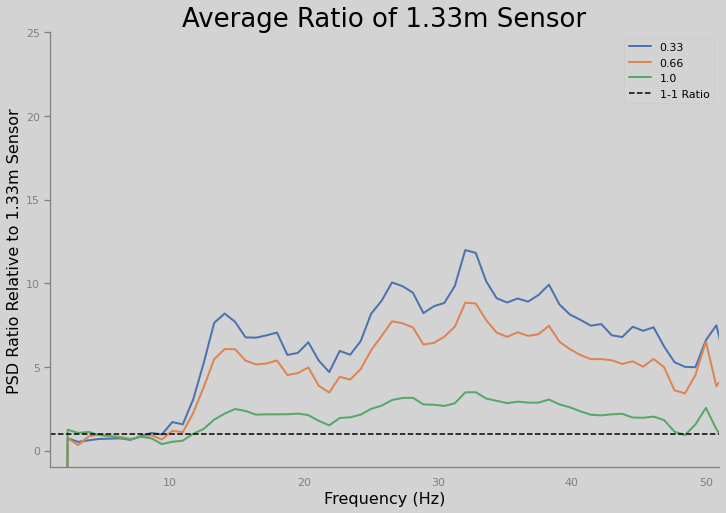

In [26]:
f, ax = plt.subplots(figsize = (12,8))
comb = avg_Pxx- pre_avg_Pxx
#comb[comb[1.33]<1e-10] = np.nan
# comb = comb.rolling(10).mean()
(comb)[[0.33,0.66,1]].div((comb)[1.33], axis = 0).plot(linewidth = 2, ax = ax)
plt.xlim(1, 51)
plt.ylim(-1, 25)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')
plt.axhline(1, linestyle='dashed', color = 'black', label = '1-1 Ratio')

legend = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
# handles, labels = handles[1:], labels[1:]
# handles.append(Line2D(xdata = [np.nan], ydata = [np.nan], color = 'black',linestyle = 'dashed', linewidth=1))
# labels.append("1-1 Ratio")

legend._legend_box = None
legend._init_legend_box(handles, labels)
legend._set_loc(legend._loc)
legend.set_title(legend.get_title().get_text())

In [28]:
10*np.log10(4)/33

0.18244242161453406

In [55]:
import warnings
warnings.filterwarnings("ignore")

def power2dB(power):
    dB = 10*np.log10(power)
    return dB

def dB2power(dB):
    power = 10**(dB/10)
    return power

def dBratio2alpha(db_ratio, z):
    return db_ratio/z

def power2alpha(ratio, z):
    dBratio = power2dB(ratio)
    return dBratio2alpha(dBratio, z)
power2alpha(10, 1)

10.0

In [57]:
dB2power(power2dB(100))

100.0

In [83]:
v = np.vectorize(power2alpha)

comb = avg_Pxx- pre_avg_Pxx
res = pd.DataFrame()

ratio = comb[[0.33,0.66,1]].div(comb[1.33], axis = 0)
for j, (i, r) in enumerate(ratio.iterrows()):
    if np.min(r.values) > 0.1:
        z = 1.33 - r.index.values
        co = v(np.abs(r.values), z)
        co = co/100
        res = pd.concat([res,  pd.DataFrame(co, index= [f'1.33-{i}' for i in r.index], columns = [i]).T])

ratio = comb[[0.33,0.66]].div(comb[1], axis = 0)
for k, (i, r) in enumerate(ratio.iterrows()):
    if np.min(r.values) > 0.1:
        z = 1 - r.index.values
        co = v(np.abs(r.values), z)
        co = co/100
        for m, col_i in enumerate(r.index):
            res.loc[i, f'1-{col_i}'] = co[m]
    # res = pd.concat([res,  pd.DataFrame(co, index= [f'1-{i}' for i in r.index], columns = [i]).T])

# ratio = comb[[0.33]].div(comb[0.66], axis = 0)
# for k, (i, r) in enumerate(ratio.iterrows()):
#     z = 0.66 - r.index.values
#     co = v(r.values, z)
#     co = co/100
#     for m, col_i in enumerate(r.index):
#         res.loc[i, f'0.66-{col_i}'] = co[m]
    # res = pd.concat([res,  pd.DataFrame(co, index= [f'1-{i}' for i in r.index], columns = [i]).T])

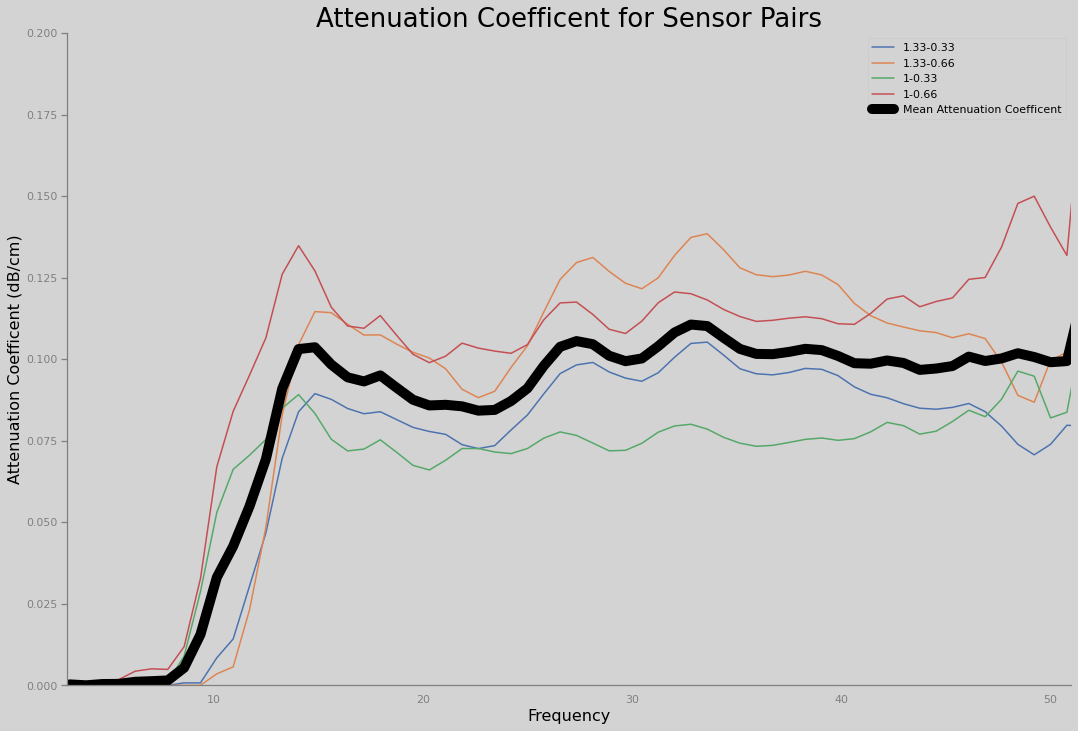

In [84]:
f, ax= plt.subplots()
res[res<0] = 0
res = res.rolling(3).mean()
res.drop('1.33-1.0', axis = 1).sort_index().plot(ax = ax) # .reindex(np.linspace(0,80, len(res)), method = 'nearest').
mean = power2dB(dB2power(res.drop('1.33-1.0', axis = 1).sort_index()).mean(axis = 1))
mean.name = 'Mean Attenuation Coefficent'
mean.plot(ax = ax, linewidth = 10, color = 'black')
plt.legend()
plt.xlim(3,51)
plt.ylim(0,0.2)
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.xlabel('Frequency')
plt.title('Attenuation Coefficent for Sensor Pairs')
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
plt.savefig(join(fig_dir, 'attenuation', 'coefficent_v1'))

Text(0, 0.5, 'PSD Ratio Relative to 1.33m Sensor')

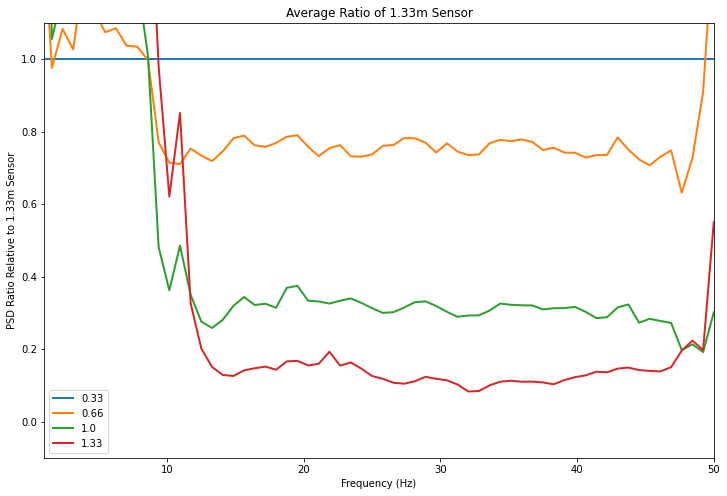

In [57]:
f, ax = plt.subplots(figsize = (12,8))
comb = avg_Pxx- pre_avg_Pxx
comb[comb[1.33]<1e-10] = np.nan
# comb = comb.rolling(10).mean()
(comb)[[0.33,0.66,1,1.33]].div((comb)[0.33], axis = 0).plot(linewidth = 2, ax = ax)
plt.xlim(1, 50)
plt.ylim(-.1, 1.1)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Outdated

## Average PSD

In [32]:
## This one doesn't normalize by pre PSD to remove sensor self noise
n = 0
avg_Pxx = np.array([])
all_psds = {}
for i, r in res[res.selected == 1].iterrows():
    if i <209:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                print(i)
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if avg_Pxx.size == 0:
                    avg_Pxx = df
                else:
                    avg_Pxx = avg_Pxx + df
                    n +=1
                all_psds[r.time] = df
        except ValueError as e:
            print(dt)
            print(e)

201
203
2022-03-20
The length of the input vector x must be greater than padlen, which is 9.
208


In [33]:
all_psds

{'2022-03-22T23:02:13.570Z':                0.33          0.66          1.00          1.33          2.00
 0.0    1.323489e-23  3.308722e-24  0.000000e+00 -1.323489e-23 -1.323489e-23
 0.1    2.484236e-07  5.529504e-08  3.612348e-08  8.073783e-08  1.351088e-07
 0.2    4.658797e-07  9.344624e-08  7.650439e-08  1.728573e-07  2.604737e-07
 0.3    6.407554e-07  1.406651e-07  1.162823e-07  2.494977e-07  3.557645e-07
 0.4    9.774233e-07  2.289920e-07  1.447319e-07  3.764537e-07  5.265518e-07
 ...             ...           ...           ...           ...           ...
 99.6   1.941136e-11  4.572044e-11  1.005029e-10  5.834766e-12  2.425576e-11
 99.7   1.954743e-11  4.518695e-11  9.040349e-11  6.440488e-12  2.013207e-11
 99.8   1.893424e-11  4.153157e-11  7.742471e-11  6.539281e-12  1.529636e-11
 99.9   1.732653e-11  3.627620e-11  6.183966e-11  5.854201e-12  7.790241e-12
 100.0  1.635463e-11  3.514295e-11  4.161061e-11  5.289576e-12  5.707643e-15
 
 [1001 rows x 5 columns],
 '2022-03-18T03:50:1

In [3]:
## This one does normalize by pre PSD to remove sensor self noise
n = 0
avg_Pxx = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        Pxx = Pxx - pre_Pxx
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if avg_Pxx.size == 0:
                    avg_Pxx = df
                else:
                    avg_Pxx = avg_Pxx + df
                    n +=1
                # plt.xlim(0, 50)      
        except ValueError as e:
            print(dt)
            print(e)

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


: 

: 

([], [])

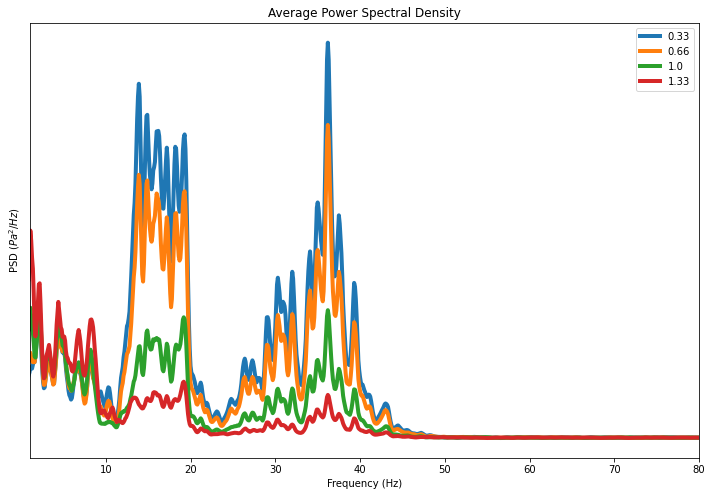

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
(avg_Pxx/n)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
plt.yticks([])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

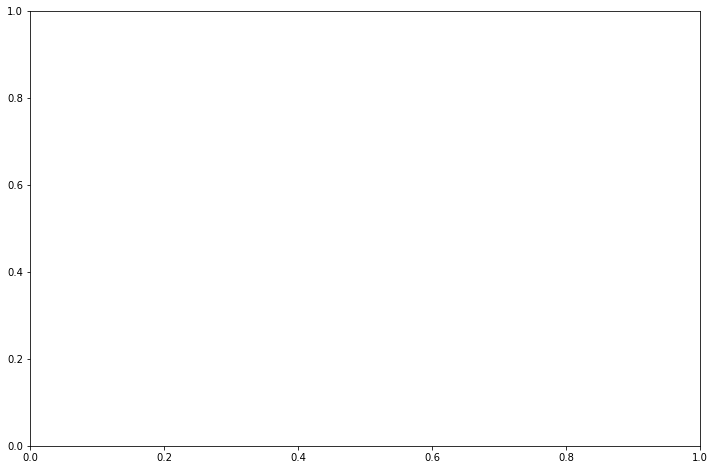

In [34]:
f, ax = plt.subplots(figsize = (12,8))
avg_Pxx[[0.33,0.66,1]].div(avg_Pxx[1.33], axis = 0).plot(linewidth = 4, ax = ax)
plt.xlim(1, 60)
plt.ylim(-1, 30)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Ratio figure

In [90]:
from copy import deepcopy
n = 0
avg_ratio = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), .1, kind = 'highpass')
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        Pxx = Pxx - pre_Pxx
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df = df[[0.33, 0.66, 1, 1.33]]
                top = df[1.33]
                top[top < 1e-12] = np.nan
                valid = deepcopy(top)
                valid[~np.isnan(valid)] = 1
                valid[np.isnan(valid)] = 0
                df = df.div(top, axis = 0).drop([1.33], axis = 1).iloc[1:]
                df.index = f[1:]
                df = np.nan_to_num(df)
                if avg_ratio.size == 0:
                    avg_ratio = df
                    valid_n = valid 
                else:
                    avg_ratio = avg_ratio + df
                    n +=1    
                    valid_n = np.add(valid_n, valid)
        except ValueError as e:
            print(dt)
            print(e)

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


Text(0, 0.5, 'PSD Ratio Relative to 1.33m Sensor')

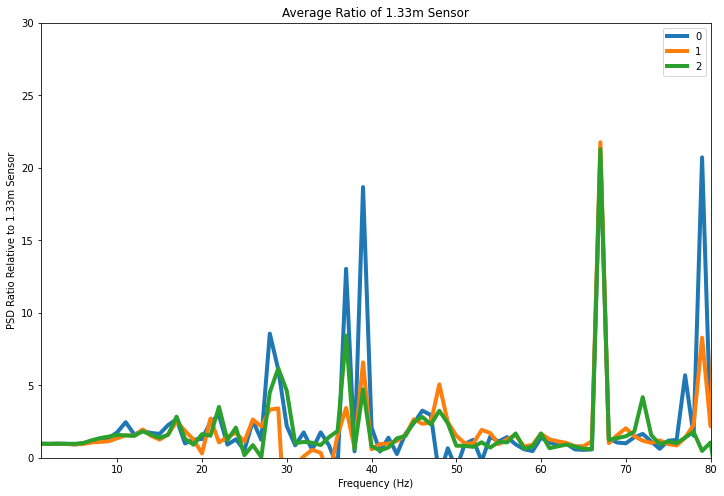

In [91]:
f, ax = plt.subplots(figsize = (12,8))
pd.DataFrame(avg_ratio / valid_n.values[1:].reshape(-1,1)).plot(linewidth = 4, ax = ax)

plt.xlim(1, 80)
plt.ylim(0, 30)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Pre PSD

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


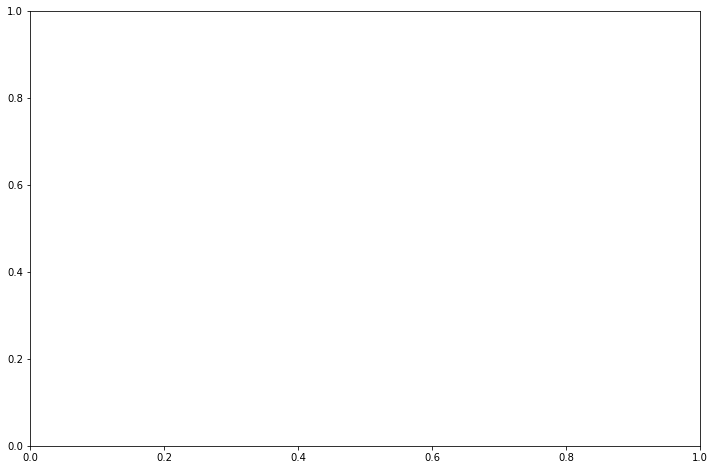

In [ ]:
n = 0
pre_avg_Pxx = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        pre_Pxx = filtfilt([1,1,1,1,1],5, pre_Pxx)
                        sig[name] = pre_Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if pre_avg_Pxx.size == 0:
                    pre_avg_Pxx = df
                else:
                    pre_avg_Pxx = pre_avg_Pxx + df
                    n +=1  
        except ValueError as e:
            print(dt)
            print(e)

([], [])

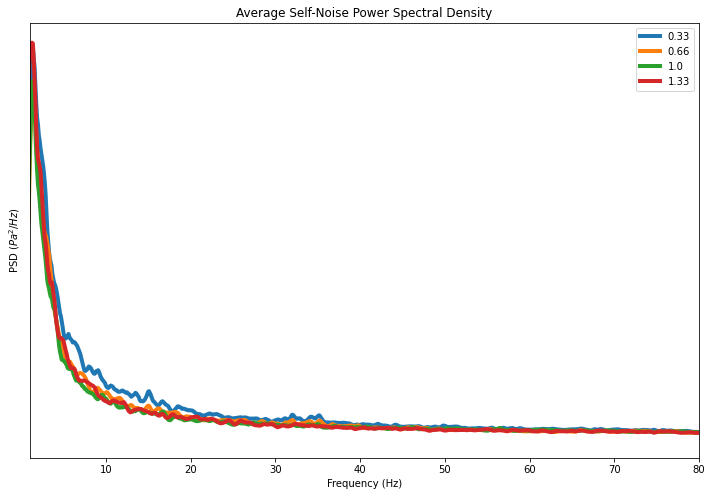

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
(pre_avg_Pxx/n)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Self-Noise Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
# plt.yscale('log')
plt.yticks([])

# Each EQ PSD

In [ ]:
eqs= 18
n = 0
f, axes = plt.subplots(1, eqs, figsize = (12,8))
for i, r in res[(res.selected == 1) & (res.mean_ratio > 5)][::-1].iterrows():
    if n < eqs:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('1 second')
        e = s + pd.Timedelta('8 second')
        try:
            if 1 in day.keys():
                    fp = day[1]
                    arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                    arr = arr[:2000]
                    ax = axes[n]
                    Sxx, f, t, im = ax.specgram(arr, Fs = sps)
                    ax.set_xticks([])
                    ax.set_xlabel(dt, rotation = 90, fontsize = 12)
                    day['snotel']['Snow Depth (cm) Start of Day Values']
                    if n == 0:
                        ax.set_yticks(np.linspace(0,100,11))
                    else:
                        ax.set_yticks([])
                    n += 1
        except ValueError as e:
            print(dt)
            print(e)
plt.tight_layout()